In [61]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
from pandas_datareader.data import DataReader


In [62]:
class MGARCH_DCC(tf.keras.Model):
    """
    Tensorflow/Keras implementation of multivariate GARCH under dynamic conditional correlation (DCC) specification.
    Further reading:
        - Engle, Robert. "Dynamic conditional correlation: A simple class of multivariate generalized autoregressive conditional heteroskedasticity models."
        - Bollerslev, Tim. "Modeling the Coherence in Short-Run Nominal Exchange Rates: A Multi-variate Generalized ARCH Model."
        - Lütkepohl, Helmut. "New introduction to multiple time series analysis."
    """
    
    def __init__(self, y):
        """
        Args:
            y: NxM numpy.array of N observations of M correlated time-series
        """
        super().__init__()
        n_dims = y.shape[1]
        self.n_dims = n_dims
        
        self.MU = tf.Variable(np.mean(y,0)) #use a mean variable
        
        self.sigma0 = tf.Variable(np.std(y,0)) #initial standard deviations at t=0
        
        #we initialize all restricted parameters to lie inside the desired range
        #by keeping the learning rate low, this should result in admissible results
        #for more complex models, this might not suffice
        self.alpha0 = tf.Variable(np.std(y,0))
        self.alpha = tf.Variable(tf.zeros(shape=(n_dims,))+0.25)
        self.beta = tf.Variable(tf.zeros(shape=(n_dims,))+0.25)
        
        self.L0 = tf.Variable(np.float32(np.linalg.cholesky(np.corrcoef(y.T)))) #decomposition of A_0
        self.A = tf.Variable(tf.zeros(shape=(1,))+0.9)
        self.B = tf.Variable(tf.zeros(shape=(1,))+0.05)
        
           
    def call(self, y):
        """
        Args:
            y: NxM numpy.array of N observations of M correlated time-series
        """
        return self.get_conditional_dists(y)
    
    
    def get_log_probs(self, y):
        """
        Calculate log probabilities for a given matrix of time-series observations
        Args:
            y: NxM numpy.array of N observations of M correlated time-series
        """
        return self.get_conditional_dists(y).log_prob(y)
    
        
    @tf.function
    def get_conditional_dists(self, y):
        """
        Calculate conditional distributions for given observations
        Args:
            y: NxM numpy.array of N observations of M correlated time-series
        """
        T = tf.shape(y)[0]
        
        #create containers for looping
        mus = tf.TensorArray(tf.float32, size = T) #observation mean container
        Sigmas = tf.TensorArray(tf.float32, size = T) #observation covariance container

        
        sigmas = tf.TensorArray(tf.float32, size = T+1)
        us = tf.TensorArray(tf.float32, size = T+1)
        Qs = tf.TensorArray(tf.float32, size = T+1)
        
        
        #initialize respective values for t=0
        sigmas = sigmas.write(0, self.sigma0)
        A0 = tf.transpose(self.L0)@self.L0
        Qs = Qs.write(0, A0) #set initial unnormalized correlation equal to mean matrix
        us = us.write(0, tf.zeros(shape=(self.n_dims,))) #initial observations equal to zero
        
        
        #convenience
        sigma0 = self.sigma0
        alpha0 = self.alpha0**2 #ensure positivity
        alpha = self.alpha
        beta = self.beta

        A = self.A
        B = self.B
        
        
        for t in tf.range(T):
            #tm1 = 't minus 1'
            #suppress conditioning on past in notation
            
            #1) calculate conditional standard deviations
            u_tm1 = us.read(t) 
            sigma_tm1 = sigmas.read(t)
            
            sigma_t = (alpha0 + alpha*sigma_tm1**2 + beta*u_tm1**2)**0.5
            
            #2) calculate conditional correlations
            u_tm1_standardized = u_tm1/sigma_tm1
                   
            Psi_tilde_tm1 = tf.reshape(u_tm1_standardized, (self.n_dims,1))@tf.reshape(u_tm1_standardized, (1,self.n_dims))

            Q_tm1 = Qs.read(t)
            Q_t = A0 + A*(Q_tm1 - A0) + B*(Psi_tilde_tm1 - A0)
            R_t = self.cov_to_corr(Q_t)
            
            #3) calculate conditional covariance
            D_t = tf.linalg.LinearOperatorDiag(sigma_t)
            Sigma_t = D_t@R_t@D_t
              
            
            #4) store values for next iteration
            sigmas = sigmas.write(t+1, sigma_t)
            us = us.write(t+1, y[t,:]-self.MU) #we want to model the zero-mean disturbances
            Qs = Qs.write(t+1, Q_t)
            
            mus = mus.write(t, self.MU)
            Sigmas = Sigmas.write(t, Sigma_t)
            
        return tfp.distributions.MultivariateNormalFullCovariance(mus.stack(), Sigmas.stack())
    
    
    def cov_to_corr(self, S):
        """
        Transforms covariance matrix to a correlation matrix via matrix operations
        Args:
            S: Symmetric, positive semidefinite covariance matrix (tf.Tensor)
        """
        D = tf.linalg.LinearOperatorDiag(1/(tf.linalg.diag_part(S)**0.5))
        return D@S@D
        
    

    def train_step(self, data):
        """
        Custom training step to handle keras model.fit given that there is no input-output structure in our model
        Args:
            S: Symmetric, positive semidefinite covariance matrix (tf.Tensor)
        """
        x,y = data
        with tf.GradientTape() as tape:
            loss = -tf.math.reduce_mean(self.get_log_probs(y))
            
        trainable_vars = self.trainable_weights
        gradients = tape.gradient(loss, trainable_vars)
        
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        
        return {"Current loss": loss}
    
    
    
    def sample_forecast(self, y, T_forecast = 30, n_samples=500):
        """
        Create forecast samples to use for monte-carlo simulation of quantities of interest about the forecast (e.g. mean, var, corr, etc.)
        WARNING: This is not optimized very much and can take some time to run, probably due to Python's slow loops - can likely be improved
        Args:
            y: numpy.array of training data, used to initialize the forecast values
            T_forecast: number of periods to predict (integer)
            n_samples: Number of samples to draw (integer)
        """
        T = tf.shape(y)[0]
        
        #create lists for looping; no gradients, thus no tf.TensorArrays needed
        #can initialize directly
        mus = []
        Sigmas = []

        us = [tf.zeros(shape=(self.n_dims,))]
        sigmas = [self.sigma0]        
        Qs = []
        
        #initialize remaining values for t=0
        A0 = tf.transpose(self.L0)@self.L0
        Qs.append(A0)
        
        
        #convenience
        sigma0 = self.sigma0 
        alpha0 = self.alpha0**2 #ensure positivity
        alpha = self.alpha
        beta = self.beta

        A = self.A
        B = self.B
        
        #'warmup' to initialize latest lagged features
        for t in range(T):
            #tm1 = 't minus 1'
            #suppress conditioning on past in notation
            u_tm1 = us[-1]
            sigma_tm1 = sigmas[-1]
            
            sigma_t = (alpha0 + alpha*sigma_tm1**2 + beta*u_tm1**2)**0.5
            
            u_tm1_standardized = u_tm1/sigma_tm1
            
            Psi_tilde_tm1 = tf.reshape(u_tm1_standardized, (self.n_dims,1))@tf.reshape(u_tm1_standardized, (1,self.n_dims))

            Q_tm1 = Qs[-1]
            Q_t = A0 + A*(Q_tm1 - A0) + B*(Psi_tilde_tm1 - A0)
            R_t = self.cov_to_corr(Q_t)
            
            D_t = tf.linalg.LinearOperatorDiag(sigma_t)
            Sigma_t = D_t@R_t@D_t
              
            
            sigmas.append(sigma_t)
            us.append(y[t,:]-self.MU) #we want to model the zero-mean disturbances
            Qs.append(Q_t)
            
            mus.append(self.MU)
            Sigmas.append(Sigma_t)
  
            
        #sample containers
        y_samples = []
        R_samples = []
        sigma_samples = []
        
        
        for n in range(n_samples):
            
            mus_samp = []
            Sigmas_samp = []

            sigmas_samp = [sigmas[-1]]
            us_samp = [us[-1]]
            Qs_samp = [Qs[-1]]
            
            #forecast containers
            ys_samp = []
            sig_samp = []
            R_samp = [] 
            
            
            for t in range(T_forecast):
                u_tm1 = us_samp[-1]
                sigma_tm1 = sigmas_samp[-1]

                sigma_t = (alpha0 + alpha**2 + beta*u_tm1**2)**0.5

                u_tm1_standardized = u_tm1/sigma_tm1
                
                Psi_tilde_tm1 = tf.reshape(u_tm1_standardized, (self.n_dims,1))@tf.reshape(u_tm1_standardized, (1,self.n_dims))

                Q_tm1 = Qs_samp[-1]
                Q_t = A0 + A*(Q_tm1 - A0) + B*(Psi_tilde_tm1 - A0)
                R_t = self.cov_to_corr(Q_t)

                D_t = tf.linalg.LinearOperatorDiag(sigma_t)
                Sigma_t = D_t@R_t@D_t


                sigmas_samp.append(sigma_t)
                Qs_samp.append(Q_t)
                
                ynext = tfp.distributions.MultivariateNormalFullCovariance(self.MU, Sigma_t).sample()
                ys_samp.append(tf.reshape(ynext,(1,1,-1)))
                sig_samp.append(tf.reshape(sigma_t,(1,1,-1)))
                R_samp.append(tf.reshape(R_t,(1,1,self.n_dims,self.n_dims)))
                
                us_samp.append(ynext-self.MU)
                
            y_samples.append(tf.concat(ys_samp,1))
            R_samples.append(tf.concat(R_samp,1))
            sigma_samples.append(tf.concat(sig_samp,1))
        
        return tf.concat(y_samples,0).numpy(), tf.concat(R_samples,0).numpy(), tf.concat(sigma_samples,0).numpy()

In [63]:
df=pd.read_csv('Data\Transformed HistoricalVariables.csv',index_col=0,parse_dates=True)
recessions =  DataReader('USREC', 'fred', start='1800')
df[f'in a recession']=recessions
df['target'] = recessions.shift(-12)

In [64]:
df.columns

Index(['RPI', 'W875RX1', 'DPCERA3M086SBEA', 'CMRMTSPL', 'RSXFS', 'INDPRO',
       'IPFPNSS', 'IPFINAL', 'IPCONGD', 'IPDCONGD',
       ...
       'UMCSENT', 'MZMSL', 'DTCOLNVHFNM', 'DTCTHFNM', 'INVEST', 'S&P: indust',
       'S&P div yield', 'S&P PE ratio', 'in a recession', 'target'],
      dtype='object', length=126)

In [66]:
df=df[['BAAFFM','T10YFFM','HOUST','target']].dropna()

In [82]:

df_train=df[:"2000"].values.astype(np.float32)

df_test=df["2000":"2021"].values.astype(np.float32)




In [83]:
X_train=df_train[:,:-1]
y_train=df_train[:,-1]
X_test=df_test[:,:-1]
y_test=df_test[:,-1]




In [84]:
model = MGARCH_DCC(X_train)

In [85]:
from scipy.stats import norm

In [86]:
out = model(X_train)

means = out.mean().numpy()
stds = out.stddev().numpy()

lowers = norm(means, stds).ppf(0.05)
uppers = norm(means, stds).ppf(0.95)

In [87]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2))

In [90]:
model.fit(X_train, X_train, batch_size=len(X_train), shuffle=False, epochs = 1, verbose=True)

ValueError: Creating variables on a non-first call to a function decorated with tf.function.

In [45]:
np.random.seed(123)
tf.random.set_seed(123)

fcast = model.sample_forecast(df_train,100,1)


In [46]:
len(fcast)

3

In [47]:
fcast[0].squeeze()

array([[-0.20552874, -0.2966682 ],
       [ 0.09906851,  0.05058376],
       [-0.13953283, -0.2043677 ],
       [-0.1500975 , -0.26448554],
       [-0.05311442, -0.02257408],
       [-0.25907874,  0.10564643],
       [-0.01637005,  0.01052015],
       [ 0.10605907,  0.19948699],
       [-0.08277628,  0.17293838],
       [-0.109478  ,  0.23774762],
       [-0.18787964,  0.28259546],
       [-0.2915875 , -0.06356177],
       [-0.2629302 ,  0.47055703],
       [ 0.09255459,  0.13151616],
       [-0.11693635,  0.04351934],
       [-0.12829782, -0.02338339],
       [ 0.0113252 , -0.0270253 ],
       [-0.1618143 ,  0.6579192 ],
       [-0.10242549,  0.56202006],
       [-0.05503345,  0.02469993],
       [-0.032426  , -0.09598593],
       [-0.22131488,  0.02681284],
       [ 0.05817828, -0.11576901],
       [-0.4711559 ,  0.1078563 ],
       [ 0.02007764, -0.1441066 ],
       [-0.4355803 , -0.02237108],
       [-0.31009373,  0.07566139],
       [ 0.27943772, -0.05792638],
       [-0.08682886,

In [54]:
df.iloc[df_test.shape[0]:]


,RPI,W875RX1
1985-09-14,0.00000,0.00000
1985-09-21,0.00000,0.00000
1985-09-28,0.00000,0.00000
1985-09-30,0.00000,0.00000
1985-10-01,0.00467,0.00513
...,...,...
2023-04-01,0.00000,0.00000
2023-04-03,0.00000,0.00000
2023-04-04,0.00000,0.00000
2023-04-05,0.00000,0.00000


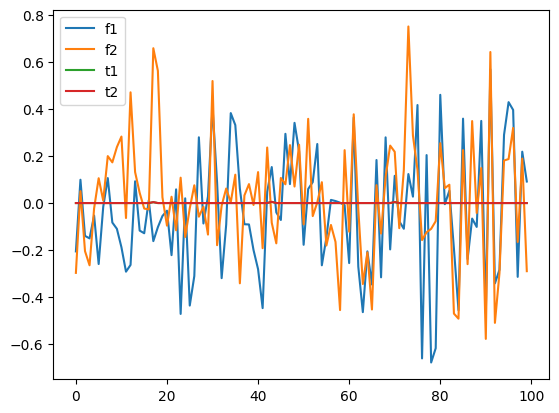

In [49]:
plt.plot(fcast[0].squeeze())
plt.plot(df_test[:100])
plt.legend(['f1','f2','t1','t2'])

In [31]:
import matplotlib.pyplot as plt

In [32]:
corrs = fcast[1][:,:,0,1]
corr_means = np.mean(corrs,0)
corr_lowers = np.quantile(corrs,0.05,0)
corr_uppers = np.quantile(corrs,0.95,0)


conditional_dists = model(np.float32(df.values))

conditional_correlations = [model.cov_to_corr(conditional_dists.covariance()[i,:,:])[0,1].numpy() for i in range(len(df))]


idx_train =  df[:-10].index
idx_test = pd.date_range( df[:-10].index[-1] + timedelta(days=1),  df[:-10].index[-1] + timedelta(days=90))

fig, axs = plt.subplots(2,1,figsize=(20,12), gridspec_kw={'height_ratios': [2, 1]})

axs[0].set_title("Conditional Correlation - DAX, S&P500", size=20)

axs[0].axhline(np.corrcoef(df.T)[0,1], c="green",alpha=0.75,ls="dashed",lw=2, label="Unconditional sample correlation")

axs[0].plot(idx_train[30:],conditional_correlations[30:-10],c="red", label="MGARCH in-sample conditional correlation")
axs[0].plot(idx_test,conditional_correlations[-10:],c="red",ls="dotted",lw=3, label="MGARCH out-of-sample conditional correlation")

axs[0].plot(idx_test, corr_means,color="blue",lw=3, alpha=0.9, label="MGARCH correlation mean forecast")
axs[0].fill_between(idx_test, corr_lowers, corr_uppers, color="blue", alpha=0.2, label="MGARCH correlation 90% forecast interval")

axs[0].grid(alpha=0.5)
axs[0].legend(prop = {"size":13})
axs[0].margins(x=0)


axs[1].set_title("Sanity check: Model predicted VS. rolling correlation",size=20)
axs[1].plot(df.index[30:],df['RPI'].values[30:],c="green", label="60 day rolling correlation")
axs[1].plot(df.index[30:],df['W875RX1'],c="red", label="MGARCH in-sample conditional correlation")
axs[1].grid(alpha=0.5)
axs[1].legend(prop = {"size":13})
axs[1].margins(x=0)

KeyboardInterrupt: 